# Trabalho Final

## Imports

In [6]:
import itertools
import pandas as pd
import numpy as np
import random
from dataclasses import dataclass as dc
from typing import Iterable
from collections import namedtuple
from plotnine import *
pd.set_option('display.max_colwidth', None)

## Functions

[T1(38), T2(33), T3(36), T4(20), T5(32), T6(29), T7(46), T8(38), T9(34), T10(40)]


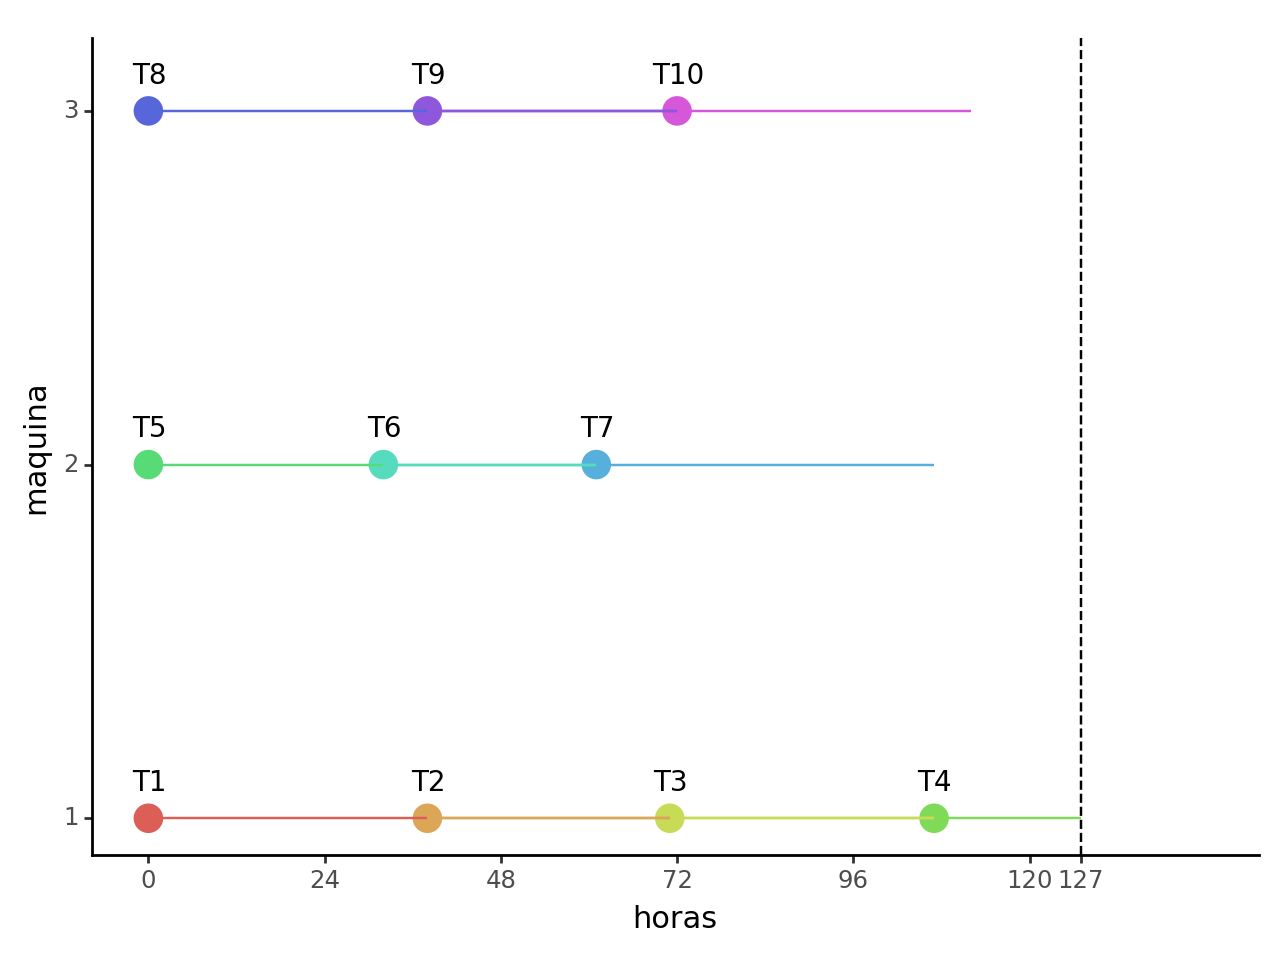

<Figure Size: (640 x 480)>

In [74]:
Numero = int # Indice da tarefa
intervalo = namedtuple("intervalo", ["inicio", "fim"])
def first(iterable, func, default=None):
  return next(filter(func, iterable), default)

@dc
class Tarefa:
  numero: int
  tempo: int
  def __repr__(self):
    return f"T{self.numero}({self.tempo})"
  def __hash__(self):
    return repr(self).__hash__()
class Tarefas:
  def __init__(self, tempos: list[int]):
    self.tarefas = [Tarefa(i+1, tempos[i]) for i in range(len(tempos))]
  
  def __getitem__(self, i: Numero | Iterable[Numero]):
    if isinstance(i, Iterable):
      return [self.tarefas[i-1] for i in i]
    return self.tarefas[i-1]

@dc 
class Maquina:
  numero: int
  n_tarefas: int
  tarefas: list[Tarefa] = None

  def __post_init__(self):
    assert self.tarefas is None or len(self.tarefas) <= self.n_tarefas
  def assignTarefas(self, tarefas: list[Tarefa]):
    assert len(tarefas) <= self.n_tarefas
    self.tarefas = tarefas
  def queueTarefa(self, tarefa: Tarefa):
    assert len(self.tarefas) < self.n_tarefas # se for igual ent n pode adicionar
    self.tarefas.append(tarefa)
  def reset(self):
    self.tarefas = []
  
  def quantoTempo(self):
    return sum(t.tempo for t in self.tarefas)
  def __repr__(self):
    return f"M{self.numero}({repr(self.tarefas)}, {self.quantoTempo()})"
  def __str__(self):
    return f"M{self.numero}"
  def isTarefaIn(self, tarefa: Tarefa | Numero):
    if isinstance(tarefa, Tarefa):
      tarefa = tarefa.numero
    return tarefa in [t.numero-1 for t in self.tarefas]
  def quandoComeca(self, tarefa: Tarefa | Numero):
    if isinstance(tarefa, Numero):
      tarefa = first(self.tarefas, lambda t: t.numero == tarefa)
    # index of tarefa in self.tarefas
    ind = self.tarefas.index(tarefa)
    return sum(t.tempo for t in self.tarefas[:ind])
  def quandoAcaba(self, tarefa: Tarefa | Numero):
    if isinstance(tarefa, Numero):
      tarefa = first(self.tarefas, lambda t: t.numero == tarefa)
    return self.quandoComeca(tarefa) + tarefa.tempo

class Horario:
  # representa as maquians e as horas que as tarefas começam
  # horario comeca completo, vindo da Permutation.getHorario()
  # Horario.timeOf("M1") -> quando acaba a maquina 1
  # Horario["T1"] -> quando começa e acaba a tarefa 1
  # Horario.whereIs("T1") -> Em que máquina está a tarefa 1
  # nota: isto pode estar dentro do permutation, mas acho melhor assim para dividir funções
  def __init__(self, maquinas: list[Maquina]):
    self.maquinas = maquinas
  def __getitem__(self, tarefa: str | Tarefa) -> intervalo:
    maq = self.whereIs(tarefa)
    if maq is None: raise KeyError(f"Tarefa {tarefa} não está no horário")
    return intervalo(maq.quandoComeca(tarefa), maq.quandoAcaba(tarefa))
  def timeOf(self, maquina: str | Maquina):
    if isinstance(maquina, str):
      maquina = self.getMaquina(maquina)
    return maquina.quantoTempo()
  def getMaquina(self, maquina: str | Numero):
    if isinstance(maquina, str): 
      return first(self.maquinas, lambda m: str(m) == maquina)
    return first(self.maquinas, lambda m: m.numero == maquina)
  def whereIs(self, tarefa: str | Tarefa):
    if isinstance(tarefa, str):
      tarefa = int(tarefa[1:])
    return first(self.maquinas, lambda m: m.isTarefaIn(tarefa))
  def plot(self):
    df = pd.DataFrame({
      "maquina": [m.numero for m in self.maquinas for t in m.tarefas ],
      "tarefa": [t.numero for m in self.maquinas  for t in m.tarefas ],
      "tarefaL": [f"T{t.numero}" for m in self.maquinas  for t in m.tarefas ],
      "comeca": [m.quandoComeca(t)   for m in self.maquinas for t in m.tarefas],
      "acaba": [m.quandoAcaba(t) for m in self.maquinas for t in m.tarefas]
    })
    return ggplot(df, aes(y = "maquina")) + \
      geom_point(aes(x = "comeca", color='factor(tarefa)'), size = 5) + \
      geom_path(aes(x = "acaba", group = "maquina", color="factor(tarefa+1)")) + \
      geom_path(aes(x = "comeca", group = "maquina", color="factor(tarefa)")) + \
      geom_vline(xintercept=df.sort_values(by=['acaba']).iloc[-1].acaba, linetype="dashed") + \
      geom_text(aes(x = "comeca", label="tarefaL"), size=10, nudge_x=0.1, nudge_y=0.1) + \
      \
      scale_x_continuous(breaks=[0, 24, 48, 72, 96, 120, df.sort_values(by=['acaba']).iloc[-1].acaba]) + \
      scale_y_continuous(breaks=[1, 2, 3]) + \
      scale_color_discrete(guide=False) + \
      coord_fixed(xlim = (-0.5, 144)) + \
      labs(x="horas", y="maquina") + \
      theme_classic() + \
      theme(aspect_ratio=0.7)
class Permutation:
  # Representação por permutação
  def __init__(self, maquinas: list[Maquina]):
    self.maquinas = maquinas
    self.n_maquinas = len(maquinas)
  def reset(self):
    for m in self.maquinas:
      m.reset()
  def machineYielder(self):
    for m in self.maquinas:
      for i in range(len(m.tarefas)):
        yield m
  def assignTarefas(self, tarefas: list[Tarefa]):
    self.reset()
    for m in self.machineYielder():
      m.queueTarefa(tarefas.pop(0))
    return self.as_list()
  def as_list(self) -> list[Tarefa]:
    return [t for m in self.maquinas for t in m.tarefas]
  def as_lists(self) -> list[list[Tarefa]]:
    return [m.tarefas for m in self.maquinas]
  def __repr__(self):
    return repr(self.as_lists())
  def getHorario(self) -> Horario:
    return Horario(self.maquinas)
  @property
  def horario(self) -> Horario:
    return self.getHorario()
  def __repr__(self):
    return repr(self.as_list())

tarefas = Tarefas([38, 33, 36, 20, 32, 29, 46, 38, 34, 40])
tarefas[1,2,4]

# exemplo 
M1 = Maquina(
  numero = 1,
  n_tarefas = 4,
  tarefas = tarefas[1,2,3,4] 
)
M2 = Maquina(
  numero = 2,
  n_tarefas = 3,
  tarefas = tarefas[5,6,7]
)
M3 = Maquina(
  numero = 3,
  n_tarefas = 3,
  tarefas = tarefas[8,9,10]
)
primeiro = Permutation([M1, M2, M3])
print(primeiro)
primeiro.horario.plot()

In [75]:
def respeitaRestricao(horario, maximos: dict[Tarefa, int]):
  for tarefa, maximo in maximos.items():
    if horario[tarefa].fim > maximo:
      return False
  return True
acabarAntes = 24*(5-1) # 1 junho (8h) até 5 junho (8h),
restricao = {
  tarefas[3]: acabarAntes,
  tarefas[4]: acabarAntes,
  tarefas[5]: acabarAntes
}
respeitaRestricao(primeiro.horario, restricao)

False

In [5]:
def verificar_cromossomo(cromossomo):
    tarefas_unicas = set(cromossomo)  # Remove duplicatas das tarefas
    if len(tarefas_unicas) == len(cromossomo):  # Verifica se todas as tarefas são únicas
        return True
    else:
        return False

In [6]:
def verificar_cromossomo2(df):
    df['Cromossoma Admissivel?'] = df.apply(lambda row: len(set(row[:10])) == 10, axis=1)
    return df

## Pergunta a)

**Neste pergunta será referida uma heurística possível para se aplicar neste problema**

1. Iremos atribuir as 3 tarefas críticas (T3, T4, T5), a cada uma das máquinas, a fim de se conseguir realizar o prazo o mais rápido possivel
2. De seguida, será colocado a tarefa mais rápida na máquina com mais tarefas
3. Por fim, serão atribuidos aleatoriamente as restantes tarefas

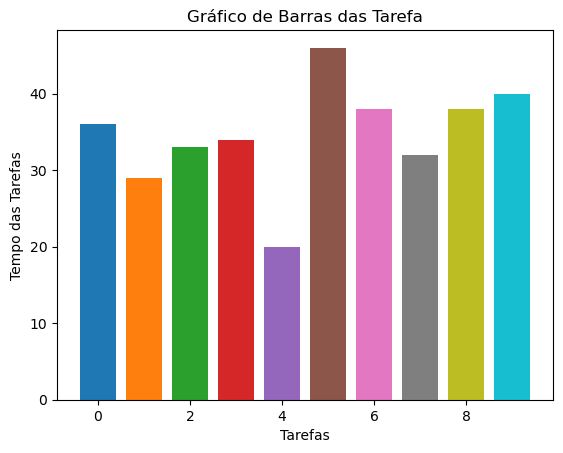

In [7]:
import matplotlib.pyplot as plt
import numpy as np

Inicio = {'T1': 38, 'T2': 33, 'T3': 36, 'T4': 20, 'T5': 32, 'T6': 29, 'T7': 46, 'T8': 38, 'T9': 34, 'T10': 40}
Heuristica = ["T3", "T6", "T2", "T9", "T4", "T7", "T1", "T5", "T8", "T10"]

# Definir uma paleta de cores personalizada
cores = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Calcular a soma dos valores de Inicio para cada máquina
somas_m1 = []
somas_m2 = []
somas_m3 = []
separadores = []

for tarefa in Heuristica:
    valor = Inicio.get(tarefa, 0)
    if tarefa in ["T3", "T4", "T5"]:
        somas_m1.append(valor)
        somas_m2.append(0)
        somas_m3.append(0)
    elif tarefa in ["T1", "T2", "T6"]:
        somas_m1.append(0)
        somas_m2.append(valor)
        somas_m3.append(0)
    else:
        somas_m1.append(0)
        somas_m2.append(0)
        somas_m3.append(valor)
    separadores.append(0)  # Adicionar o valor 0 para separar as tarefas

# Configurar as cores para cada tarefa
cores_tarefas = [cores[i % len(cores)] for i in range(len(Heuristica))]

# Criar a figura e os eixos do gráfico
fig, ax = plt.subplots()

# Plotar as barras do gráfico
ax.bar(np.arange(len(Heuristica)), somas_m1, color=cores_tarefas)
ax.bar(np.arange(len(Heuristica)), somas_m2, bottom=somas_m1, color=cores_tarefas)
ax.bar(np.arange(len(Heuristica)), somas_m3, bottom=np.add(somas_m1, somas_m2), color=cores_tarefas)

# Adicionar a linha separadora entre as tarefas
ax.plot(np.arange(len(Heuristica)), separadores, color='black', linewidth=0.5)

# Configurar o xlabel e ylabel
ax.set_xlabel("Tarefas")
ax.set_ylabel("Tempo das Tarefas")

# Configurar o título do gráfico
ax.set_title("Gráfico de Barras das Tarefa")

# Mostrar o gráfico
plt.show()

## Pergunta b)

In [8]:
Heuristica = ["T3", "T6", "T2", "T9", "T4", "T7", "T1", "T5", "T8", "T10"]

In [9]:
df_heuristica = pd.DataFrame([Heuristica], columns=colunas)
df_heuristica

,M1_T1,M1_T2,M1_T3,M1_T4,M2_T1,M2_T2,M2_T3,M3_T1,M3_T2,M3_T3
0,T3,T6,T2,T9,T4,T7,T1,T5,T8,T10


In [10]:
df_permutations = df_heuristica.copy()
DemoraMaquina(df_permutations)
RespeitaRestricao(df_permutations)
df_permutations

,M1_T1,M1_T2,M1_T3,M1_T4,M2_T1,M2_T2,M2_T3,M3_T1,M3_T2,M3_T3,MaquinaDemora,Restrição Respeitada?
0,T3,T6,T2,T9,T4,T7,T1,T5,T8,T10,132,True


In [11]:
print("=================================================================")
for coluna in df_permutations.columns[:4]:
    primeira_linha = df_permutations[coluna].iloc[0]
    print(f" ⚫ A \033[1mmáquina 1\033[0m possui a \033[1mtarefa{primeira_linha}\033[0m, que possui uma \033[1mduração de {Inicio.get(primeira_linha)}\033[0m")
for coluna in df_permutations.columns[4:7]:
    primeira_linha = df_permutations[coluna].iloc[0]
    print(f" ⚫ A \033[1mmáquina 2\033[0m possui a \033[1mtarefa{primeira_linha}\033[0m, que possui uma \033[1mduração de {Inicio.get(primeira_linha)}\033[0m")
for coluna in df_permutations.columns[7:]:
    primeira_linha = df_permutations[coluna].iloc[0]
    print(f" ⚫ A \033[1mmáquina 3\033[0m possui a \033[1mtarefa{primeira_linha}\033[0m, que possui uma \033[1mduração de {Inicio.get(primeira_linha)}\033[0m")
print("=================================================================")

 ⚫ A máquina 1 possui a tarefaT3, que possui uma duração de 36
 ⚫ A máquina 1 possui a tarefaT6, que possui uma duração de 29
 ⚫ A máquina 1 possui a tarefaT2, que possui uma duração de 33
 ⚫ A máquina 1 possui a tarefaT9, que possui uma duração de 34
 ⚫ A máquina 2 possui a tarefaT4, que possui uma duração de 20
 ⚫ A máquina 2 possui a tarefaT7, que possui uma duração de 46
 ⚫ A máquina 2 possui a tarefaT1, que possui uma duração de 38
 ⚫ A máquina 3 possui a tarefaT5, que possui uma duração de 32
 ⚫ A máquina 3 possui a tarefaT8, que possui uma duração de 38
 ⚫ A máquina 3 possui a tarefaT10, que possui uma duração de 40
 ⚫ A máquina 3 possui a tarefa132, que possui uma duração de None
 ⚫ A máquina 3 possui a tarefaTrue, que possui uma duração de None


É possível visualizar que a restrição foi respeitada

## Pergunta c)

In [12]:
Cromossoma = '[' + ', '.join([f"'{valor}'" for valor in Heuristica]) + ']'
print(Cromossoma)

['T3', 'T6', 'T2', 'T9', 'T4', 'T7', 'T1', 'T5', 'T8', 'T10']


Nota:
- As 4 primeiras tarefas correspondem à máquina 1
- Da 5 à 7 tarefas correspondem à máquina 2
- As restantes tarefas correspondem à máquina 3

## Pergunta d)

**Operador de cromossoma**

### Crossover Uniforme

In [33]:
import random
import copy

heuristica = ["T3", "T6", "T2", "T9", "T4", "T7", "T1", "T5", "T8", "T10"]

def CrossUniforme(heuristica):
    pai1 = copy.deepcopy(heuristica)
    pai2 = copy.deepcopy(heuristica)
    random.shuffle(pai2)

    filho1 = []
    filho2 = []

    for i in range(len(heuristica)):
        if random.random() < 0.5:  # Seleciona aleatoriamente entre os pais
            filho1.append(pai1[i])
            filho2.append(pai2[i])
        else:
            filho1.append(pai2[i])
            filho2.append(pai1[i])
    return filho1, filho2

filho1, filho2 = CrossUniforme(heuristica)

In [34]:
df_filhos = pd.DataFrame()

for i, coluna in enumerate(df_heuristica.columns):
    df_filhos[coluna] = [filho1[i], filho2[i]]
DemoraMaquina(df_filhos)
RespeitaRestricao(df_filhos)
verificar_cromossomo2(df_filhos)
df_filhos

,M1_T1,M1_T2,M1_T3,M1_T4,M2_T1,M2_T2,M2_T3,M3_T1,M3_T2,M3_T3,MaquinaDemora,Restrição Respeitada?,Cromossoma Admissivel?
0,T3,T8,T7,T9,T4,T4,T1,T2,T8,T10,154,True,False
1,T5,T6,T2,T6,T1,T7,T10,T5,T9,T3,124,False,False


In [15]:
df_filhos['Cromossoma Admissivel?'] = df_filhos.apply(lambda row: len(set(row[:10])) == 10, axis=1)
df_filhos

,M1_T1,M1_T2,M1_T3,M1_T4,M2_T1,M2_T2,M2_T3,M3_T1,M3_T2,M3_T3,MaquinaDemora,Restrição Respeitada?,Cromossoma Admissivel?
0,T3,T5,T9,T9,T10,T7,T1,T6,T1,T10,136,True,False
1,T2,T6,T2,T8,T4,T7,T4,T5,T8,T3,133,False,False


In [16]:
df_heuristica.columns

Index(['M1_T1', 'M1_T2', 'M1_T3', 'M1_T4', 'M2_T1', 'M2_T2', 'M2_T3', 'M3_T1',
       'M3_T2', 'M3_T3'],
      dtype='object')

### Crossover a 1 Ponto

In [17]:
Heuristica = ["T3", "T6", "T2", "T9", "T4", "T7", "T1", "T5", "T8", "T10"]

In [18]:
def crossover_um_ponto(pai1, pai2):
    ponto_corte = random.randint(1, len(pai1) - 1)
    filho1 = pai1[:ponto_corte] + pai2[ponto_corte:]
    filho2 = pai2[:ponto_corte] + pai1[ponto_corte:]
    print(f"K={ponto_corte}")
    return filho1, filho2

pai1 = copy.deepcopy(heuristica)
pai2 = copy.deepcopy(heuristica)
random.shuffle(pai2)

filho1, filho2 = crossover_um_ponto(pai1, pai2)
print("Filho 1:", filho1)
print("Filho 2:", filho2)

K=4
Filho 1: ['T3', 'T6', 'T2', 'T9', 'T1', 'T6', 'T5', 'T8', 'T7', 'T4']
Filho 2: ['T9', 'T3', 'T2', 'T10', 'T4', 'T7', 'T1', 'T5', 'T8', 'T10']


In [19]:
df_filhos = pd.DataFrame()

for i, coluna in enumerate(df_heuristica.columns):
    df_filhos[coluna] = [filho1[i], filho2[i]]
DemoraMaquina(df_filhos)
RespeitaRestricao(df_filhos)
verificar_cromossomo2(df_filhos)
df_filhos

,M1_T1,M1_T2,M1_T3,M1_T4,M2_T1,M2_T2,M2_T3,M3_T1,M3_T2,M3_T3,MaquinaDemora,Restrição Respeitada?,Cromossoma Admissivel?
0,T3,T6,T2,T9,T1,T6,T5,T8,T7,T4,132,True,False
1,T9,T3,T2,T10,T4,T7,T1,T5,T8,T10,143,True,False


## Pergunta e)

**Operador de Mutação**

### Mutação por troca

In [52]:
def mutacao_troca(cromossomo, probabilidade=.1):
    cromossomo_mutado = copy.deepcopy(cromossomo)
    
    # Verificar se a mutação será aplicada com base na probabilidade
    if random.random() < probabilidade:
        # Selecionar aleatoriamente duas posições diferentes no cromossomo
        posicao1 = random.randint(0, len(cromossomo)-1)
        posicao2 = random.randint(0, len(cromossomo)-1)
        
        # Realizar a troca entre as duas posições
        cromossomo_mutado[posicao1], cromossomo_mutado[posicao2] = cromossomo_mutado[posicao2], cromossomo_mutado[posicao1]
    
    return cromossomo_mutado

In [53]:
filho1, filho2 = CrossUniforme(heuristica)

In [54]:
print(filho1, "\n",filho2)

['T3', 'T3', 'T4', 'T2', 'T4', 'T10', 'T1', 'T8', 'T8', 'T5'] 
 ['T7', 'T6', 'T2', 'T9', 'T1', 'T7', 'T9', 'T5', 'T6', 'T10']


In [55]:
filho1 = mutacao_troca(filho1)
filho2 = mutacao_troca(filho2)

In [57]:
print(filho1, "\n", filho2)

['T3', 'T3', 'T4', 'T2', 'T4', 'T10', 'T1', 'T8', 'T8', 'T5'] 
 ['T7', 'T6', 'T2', 'T9', 'T1', 'T7', 'T9', 'T5', 'T6', 'T10']


## Pergunta f)

**Tipos de inadmissibilidades que não permitem obter soluções admissiveis**

### Cromossomas inadmissiveis

    No contexto deste problema, um cromossoma inadmissivel é um cromossoma que não possui todas as tarefas.
    Em baixo iremos aplicar o crossover de um ponto que, maior parte das vezes, devolve uma solução inadmissivel, podendo então usar como exemplo

In [80]:
filho1, filho2 = crossover_um_ponto(pai1, pai2)
filho1, filho2

K=5


(['T3', 'T6', 'T2', 'T9', 'T4', 'T6', 'T5', 'T8', 'T7', 'T4'],
 ['T9', 'T3', 'T2', 'T10', 'T1', 'T7', 'T1', 'T5', 'T8', 'T10'])

Analisando com atenção, podemos verificar que estes cromossomas filho não admissíveis, sendo necessário tratá-los. \
Em baixo, podemos visualizar um exemplo de como corrigir estes cromossomas

    i. Identificar a tarefa que não está a ser realizada;
    ii. Identificar a tarefa que está a ser realizada por dois trabalhadores;
    iii. No primeiro gene com o valor da tarefa que é realizada por dois trabalhadores, altera-se o valor para a tarefa que não estava a ser realizada.

In [81]:
def corrigirCromossoma(lista_tarefas):
    All = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10']
    repetido = []
    falta = []
    new_list = []
    for i in All:
        if i not in lista_tarefas:
            falta.append(i)
    if len(falta) == 0:
        return lista_tarefas
    for i in lista_tarefas:
        if i not in repetido:
            new_list.append(i)
            repetido.append(i)
        else:
            new_list.append(falta[0])
            falta.pop(0)
    return new_list

In [82]:
corrigirCromossoma(filho1)

['T3', 'T6', 'T2', 'T9', 'T4', 'T1', 'T5', 'T8', 'T7', 'T10']

**Nota: \
Também podemos referir várias Mutações/Restrições que não respeitam as restrições das 96 horas, sendo possível visualizar vários exemplos disso ao longo do código. \
Uma forma de resolver seria rejeitar estes filhos.**

## Pergunta g)

- - -